### Introduction

In this notebook we will do image captioning on Microsoft COCO Dataset. We will be downloading the validation set, that contains around 41000 images for training. The data can be downloaded from [here](http://cocodataset.org/#download) form. 

We will also use Keras for training. For converting the images to vectors we will use the VGG16, pretrained model in Keras

I will be following the instructions at [this](https://fairyonice.github.io/Develop_an_image_captioning_deep_learning_model_using_Flickr_8K_data.html) URL for this notebook.

In [159]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

model = VGG16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________


We see that the last layer in the summary is used to classify the image into 1000 classes. Our objective is not to classify but to get a vector representation of the image. We therefore want to pop the last layer of this model and need the final layer to be `fc2`, which gives us a vector of dimension  4096.

Check the summary below after we pop the final layer off

In [160]:
#Pop off final layer, as if its a stack of layers with the head of the stack as the final layer
model.layers.pop()
model = Model(inputs = model.input, outputs = model.layers[-1].output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________


We will now download the dataset of it doesn't exists locally

In [161]:
from urllib.request import urlretrieve
import os
import zipfile

def maybe_download(zip_file_url, local_file_name, local_dir):
    local_full_file = os.path.join(local_dir, local_file_name)
    if not os.path.exists(local_dir):
        os.mkdir(local_dir)
    else:
        print('Directory "%s" exist'%local_dir)
        
    if os.path.exists(local_full_file):
        print('Validation zip %s exists, not downloading'%local_full_file)
    else:
        print('Downloading %s'%zip_file_url)
        urlretrieve(zip_url, local_full_file)
        print('File successfully downloaded')
     
    extraction_directory = os.path.join(local_dir, local_file_name[0:-4])
    
    if not os.path.exists(extraction_directory):        
        print('Unzipping file')
        os.mkdir(extraction_directory)
        zip_file = zipfile.ZipFile(local_full_file, 'r')
        zip_file.extractall(extraction_directory)
        zip_file.close()
        print('Zip file successfully extracted')
    else:
        print('Zip file already extracted')
    

print('\nDownloading Images')      
zip_url = 'http://images.cocodataset.org/zips/val2014.zip'
local_file_name = 'train_data.zip'
local_dir = 'coco-dataset'
maybe_download(zip_url, local_file_name, local_dir)
    
print('\nDownloading annotations')
zip_url = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
local_file_name = 'train_annotations.zip'
local_dir = 'coco-dataset'
maybe_download(zip_url, local_file_name, local_dir)
    


Directory "coco-dataset" exist
Validation zip coco-dataset/train_data.zip exists, not downloading
Zip file already extracted

Directory "coco-dataset" exist
Validation zip coco-dataset/train_annotations.zip exists, not downloading
Zip file already extracted


Create a dictionary of captions and image names

In [233]:
import json
import string
with open(os.path.join(local_dir, 'train_annotations', 'annotations', 'captions_val2014.json')) as f:
    annotations = json.load(f)
    
    def process_caption(caption):
        splits = caption.split()
        table = str.maketrans('', '', string.punctuation)
        
        splits = [w.lower() for w in splits]
        splits = [w.translate(table) for w in splits]
        splits = [w for w in splits if len(w) > 1 and w.isalpha()]        
        
        return 'startseq ' + ' '.join(splits) + ' endseq'
    
    image_id_to_image_dict = {i['id']: os.path.join(local_dir, 'train_data', 'val2014', i['file_name']) for i in annotations['images']}
    image_id_to_caption_dict = {i['image_id']: process_caption(i['caption']) for i in annotations['annotations']}

 
 Let us preview 5 random images

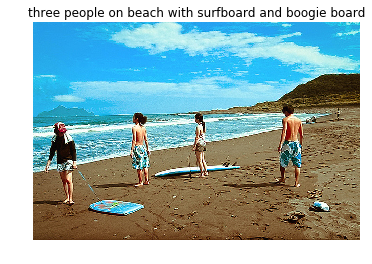

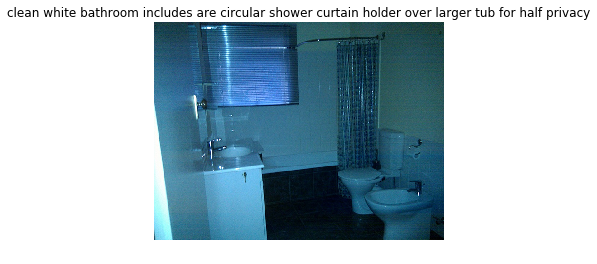

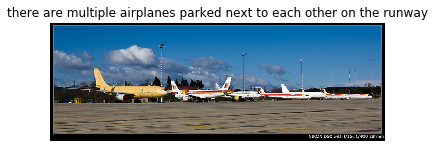

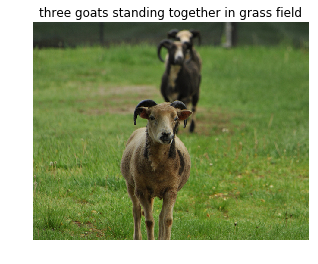

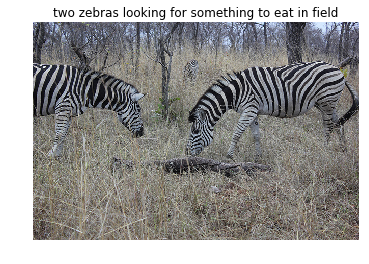

In [234]:
import matplotlib.pyplot as plt
from PIL import Image
import random

def show_image_with_caption(image_id):
    im = Image.open(image_id_to_image_dict[image_id])
    fig = plt.imshow(im)
    ax = plt.gca()
    caption = image_id_to_caption_dict[image_id].split()
    ax.set_title(' '.join(caption[1:-1]))
    plt.axis('off');
    plt.show()


keys = list(image_id_to_image_dict.keys())

random_5 = [ random.choice(keys) for _ in range(5)]

for img_id in random_5:
    show_image_with_caption(img_id)
    



Next step is to iterate through all images in the dataset and create a dictionary of the image vectors

In [235]:
import numpy as np
from pickle import dump
import os

def load_image_feature_vectors(feature_vector_pickle_file):

    if os.path.exists(feature_vector_pickle_file):
        print('Found pickle file, loading dictionary from it')
        with open(feature_vector_pickle_file, 'rb') as f:
            features = pickle.load(f)
            
        print('Loaded features')
        
    else:
        print('Pickle file not found, building feature vectors, this will take long')
        features = dict()
        file_names = image_id_to_image_dict.items()
        deleted_images = []
        print('Generating image vectors\n')
        for idx, entry in enumerate(file_names):
            image_id, img_file = entry
            if not os.path.exists(img_file):
                print('Image file', img_file, 'doest not exist')
                deleted_images.append(image_id)
                continue

            img = Image.open(img_file)
            img = img.resize((224, 224), Image.ANTIALIAS)
            img_arr = np.array(img)
            if len(img_arr.shape) != 3:
                deleted_images.append(image_id)
                print('Image %s '%img_file, 'has shape,', img_arr.shape, 'skipping it from processing')
                continue

            height, width, channels = img_arr.shape
            img_arr = img_arr.reshape(1, height, width, channels)
            img_vector = model.predict(img_arr)
            features[image_id] = img_vector
            if idx > 0 and idx % 10000 == 0:
                print('Processed %d images'%idx)

        with open(feature_vector_pickle_file, 'wb') as f:
            dump(features, f)
            
    return features

features = load_image_feature_vectors('coco_images_features.pkl')

Found pickle file, loading dictionary from it
Loaded features


We see some of the images above are not processed as they probably are gray scale and we will remove them from the dictionaries created. At this point we have the following in these variables

- `image_id_to_image_dict`: Which contains the numeric image id and the location of the image file
- `image_id_to_caption_dict`: Which contains the image id and the caption associated with that image, however, the caption is changed to ensure that we 
    - Convert everything to lowercase
    - Change words thats numeric
    - Remove punctuations
    - Each sentence starts with a text `startseq` and ends with `endseq`
- `features`: 4096 dimension vector for the image contained on the file system

Image file is coco-dataset/train_data/val2014/COCO_val2014_000000264594.jpg
Image caption is startseq two girls standing next to black and white animal endseq
Image vector dimension is (1, 4096)


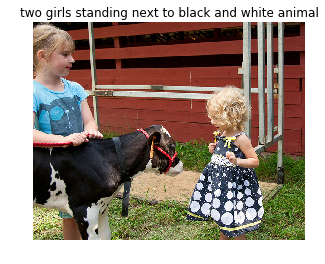

In [236]:
image_id = 264594
print('Image file is', image_id_to_image_dict[image_id])
print('Image caption is', image_id_to_caption_dict[image_id])
print('Image vector dimension is', features[image_id].shape)
show_image_with_caption(image_id)

Let is look at the size of our vocabulary

In [269]:
import collections
from functools import reduce
all_words = collections.Counter(
    [w for k in image_id_to_caption_dict for w in image_id_to_caption_dict[k].split()]).most_common()

max_len_sentence = reduce(
    lambda curr_max, curr: max(curr_max, len(curr.split())), 
    list(image_id_to_caption_dict.values()), 0)

print('Vocabulalary size is', len(all_words))
print('10 Most common words are', all_words[0:10])
print('Max length sentence is', max_len_sentence)

Vocabulalary size is 9561
10 Most common words are [('startseq', 40504), ('endseq', 40504), ('on', 14792), ('the', 14173), ('of', 13477), ('in', 12816), ('with', 10678), ('and', 9757), ('is', 7071), ('man', 4837)]
Max length sentence is 43



Let us create a keras tokenizer.
The tokenizer essentially does a similar activity as we did with Counter in last well and gives us some utility functions to convert sentences to numeric vectors

In [277]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts([image_id_to_caption_dict[k] for k in image_id_to_caption_dict])

print('Trying sample invocation of tokenizer.texts_to_sequences')
print('Input text sentence is "', image_id_to_caption_dict[image_id], '"')
print(tokenizer.texts_to_sequences([image_id_to_caption_dict[image_id]])[0])

Trying sample invocation of tokenizer.texts_to_sequences
Input text sentence is " startseq two girls standing next to black and white animal endseq "
[1, 14, 434, 18, 19, 11, 36, 8, 20, 415, 2]



With the Tokenizer in place, we will now prepare the required input

TODO: Work on preparing the input data sequence